In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from imblearn.under_sampling import OneSidedSelection, TomekLinks, EditedNearestNeighbours

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('../datasets/BankChurners.csv')
data = data.iloc[:,1:21]
np.random.seed(42)

In [4]:
import tensorflow as tf

def metric_precision(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 return precision

def metric_recall(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 recall=TP/(TP+FN)
 return recall

#F1-score    
def metric_F1score(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 recall=TP/(TP+FN)
 F1score=2*precision*recall/(precision+recall)
 return F1score

In [6]:
object_columns = data.select_dtypes('object').columns
for i in object_columns:
    lb = LabelEncoder()
    lb.fit(data[i])
    data[i] = lb.transform(data[i])
    print(f'category : {np.unique(data[i])}\nclasses : {lb.classes_}\n')

input = data.iloc[:,1:]
target = data.iloc[:,0]

category : [0 1]
classes : ['Attrited Customer' 'Existing Customer']

category : [0 1]
classes : ['F' 'M']

category : [0 1 2 3 4 5 6]
classes : ['College' 'Doctorate' 'Graduate' 'High School' 'Post-Graduate'
 'Uneducated' 'Unknown']

category : [0 1 2 3]
classes : ['Divorced' 'Married' 'Single' 'Unknown']

category : [0 1 2 3 4 5]
classes : ['$120K +' '$40K - $60K' '$60K - $80K' '$80K - $120K' 'Less than $40K'
 'Unknown']

category : [0 1 2 3]
classes : ['Blue' 'Gold' 'Platinum' 'Silver']



In [7]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

y_train= to_categorical(y_train)
y_test= to_categorical(y_test)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8101, 19) (2026, 19) (8101, 2) (2026, 2)


##### BatchNormalization https://eehoeskrap.tistory.com/430


---------

-----------

In [9]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

oss = OneSidedSelection(random_state=42)
x_train, y_train = oss.fit_resample(x_train, y_train)
print((y_train==1).sum(), (y_train==0).sum())
# y_train= to_categorical(y_train)
# y_test= to_categorical(y_test)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

6512 1300
(7812, 19) (2026, 19) (7812,) (2026,)


In [109]:
model = Sequential()

model.add(keras.Input(shape=(8,)))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		metric_precision,
	 		metric_recall,
	 		metric_F1score,
			 ])
            
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_62 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dense_92 (Dense)            (None, 128)               1152      
                                                                 
 batch_normalization_63 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_93 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_64 (Bat  (None, 64)             

In [110]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test F1 Score : %.4f' % (model.evaluate(x_test, y_test)[4]))


Epoch 1: val_loss improved from inf to 0.26267, saving model to ./model\01-0.262668.hdf5

Epoch 2: val_loss improved from 0.26267 to 0.19459, saving model to ./model\02-0.194589.hdf5

Epoch 3: val_loss improved from 0.19459 to 0.17649, saving model to ./model\03-0.176487.hdf5

Epoch 4: val_loss improved from 0.17649 to 0.17254, saving model to ./model\04-0.172537.hdf5

Epoch 5: val_loss improved from 0.17254 to 0.17102, saving model to ./model\05-0.171021.hdf5

Epoch 6: val_loss improved from 0.17102 to 0.16839, saving model to ./model\06-0.168389.hdf5

Epoch 7: val_loss improved from 0.16839 to 0.16394, saving model to ./model\07-0.163944.hdf5

Epoch 8: val_loss improved from 0.16394 to 0.16089, saving model to ./model\08-0.160890.hdf5

Epoch 9: val_loss did not improve from 0.16089

Epoch 10: val_loss improved from 0.16089 to 0.15210, saving model to ./model\10-0.152099.hdf5

Epoch 11: val_loss improved from 0.15210 to 0.15118, saving model to ./model\11-0.151177.hdf5

Epoch 12: val

In [129]:
a = model.evaluate(x_test, y_test)
a

64/64 [==============================] - 0s 2ms/step - loss: 0.1251 - accuracy: 0.9536 - metric_precision: 0.9701 - metric_recall: 0.9750 - metric_F1score: 0.9722


[0.12513606250286102,
 0.9536031484603882,
 0.9701271057128906,
 0.9749970436096191,
 0.9721640348434448]

In [116]:
pred = model.predict(x_test)
pred

array([[0.99293   ],
       [0.99971277],
       [0.9740361 ],
       ...,
       [0.9979457 ],
       [0.90619665],
       [0.9939766 ]], dtype=float32)

In [120]:
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0


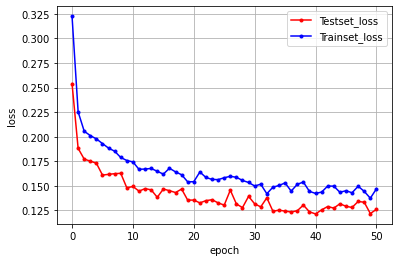

In [93]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history["loss"]

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

------------

---------------------

In [94]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

y_train= to_categorical(y_train)
y_test= to_categorical(y_test)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8101, 8) (2026, 8) (8101, 2) (2026, 2)


In [95]:
model = Sequential()

model.add(keras.Input(shape=(8,)))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		metric_precision,
	 		metric_recall,
	 		metric_F1score,
			 ])
            
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_59 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dense_88 (Dense)            (None, 128)               1152      
                                                                 
 batch_normalization_60 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_89 (Dense)            (None, 64)                8256      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_61 (Bat  (None, 64)             

In [96]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test F1 Score : %.4f' % (model.evaluate(x_test, y_test)[4]))


Epoch 1: val_loss improved from inf to 0.27284, saving model to ./model\01-0.272842.hdf5

Epoch 2: val_loss improved from 0.27284 to 0.20331, saving model to ./model\02-0.203308.hdf5

Epoch 3: val_loss improved from 0.20331 to 0.18805, saving model to ./model\03-0.188051.hdf5

Epoch 4: val_loss improved from 0.18805 to 0.17803, saving model to ./model\04-0.178034.hdf5

Epoch 5: val_loss improved from 0.17803 to 0.17697, saving model to ./model\05-0.176970.hdf5

Epoch 6: val_loss improved from 0.17697 to 0.17028, saving model to ./model\06-0.170278.hdf5

Epoch 7: val_loss improved from 0.17028 to 0.16889, saving model to ./model\07-0.168890.hdf5

Epoch 8: val_loss improved from 0.16889 to 0.16434, saving model to ./model\08-0.164341.hdf5

Epoch 9: val_loss did not improve from 0.16434

Epoch 10: val_loss improved from 0.16434 to 0.15653, saving model to ./model\10-0.156526.hdf5

Epoch 11: val_loss did not improve from 0.15653

Epoch 12: val_loss did not improve from 0.15653

Epoch 13: 

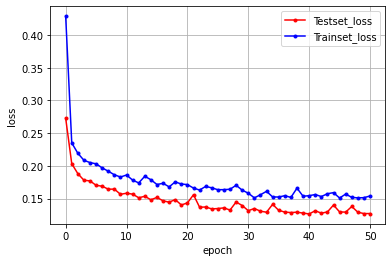

In [97]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history["loss"]

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()